# Import

In [1]:
import PyPDF2
import pandas as pd
import re
import numpy as np
import os
import fitz
from PIL import Image
import io
from functools import partial
import scipy
import skimage
from pyproj import Geod
import cv2 as cv
from scipy import ndimage as ndi
import copy
from numba import njit

from collections import Counter

from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from scipy.spatial.distance import cdist

from skimage.morphology import remove_small_objects

import pylab
from matplotlib.colors import to_hex
import matplotlib.pyplot as plt

import simplekml

from skimage.io import imread
from scipy import ndimage as ndi
from skimage import feature
from skimage.color import rgb2gray 
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
import matplotlib.pyplot as plt
from skimage import filters

from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial

base_dir = '/home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting'

In [2]:
table = pd.read_csv(base_dir + '/example_table.csv', dtype=str, sep='\t')
table['Threatened Species'] = 'None mentioned'
table['Map'] = False
species = pd.read_csv('threatened_species_202010.csv')

Extract "Threatened Species" and "Map?" column.

In [3]:
example_folders = [x[0].replace('/','') + '_' + x[1].replace('/','') for x in table[['Reference Number', 'Date of notice']].values]

In [4]:
# Check for scientific names 
# Loop through pdf files. Convert pdf to text. Search for scientific names.
folders = os.listdir("./files")

In [5]:
folders_revised = []
for folder in folders:
    for example_folder in example_folders:
        if example_folder in folder:
            folders_revised.append(folder)

In [6]:
folders_revised = list(set(folders_revised))
len(folders_revised)

93

In [7]:
folders=folders_revised

In [ ]:
# Loop through folders
for folder in folders_revised:
    print(folder)
    try:
        fn = folder.split('_')[0] + '_' + folder.split('_')[1] + '_combined.pdf'
        pdf_file_obj = open(base_dir + '/files/' + folder + '/' + fn, 'rb')
        pdf_reader = PyPDF2.PdfFileReader(pdf_file_obj)
    except:
        try:
            fn = folder + '_combined.pdf'
            pdf_file_obj = open(base_dir + '/files/' + folder + '/' + fn, 'rb')
            pdf_reader = PyPDF2.PdfFileReader(pdf_file_obj)
        except:
            continue

    try:
        pages = [
            pdf_reader.getPage(i).extractText().replace('\n', '') 
            for i in range(pdf_reader.numPages)
        ]
    except:
        continue
    text = ''.join(pages)
    
    text_lower = text.lower()
    sci_name = species['Scientific Name'].apply(lambda x: x.lower()).values
    comm_name = species['Common Name'].loc[
        np.logical_and(
            species['Common Name'] != 'a shrub', species['Common Name'] != '-'
        )
    ].apply(lambda x: x.lower()).values

    [sci_name_exist, comm_name_exist] = [
        [
            species['Common Name'].values[i] + ', ' 
            + species['Scientific Name'].values[i] + ' (' 
            +  species['Threatened status'].values[i] + ')' 
            for i in range(len(name)) if name[i] in text.lower()
        ]
        for name in [sci_name, comm_name]
    ]
    
    if 'coordinates' in text.lower() or 'latitude' in text.lower() or 'longitude' in text.lower() or ' map ' in text.lower():
        coordinates_mentioned = True
    else:
        coordinates_mentioned = False

    species_mentioned = sorted(
        list(set(sci_name_exist).union(set(comm_name_exist)))
    )
    species_mentioned = ', '.join(species_mentioned)
    
#     Extract text coordinates
#     text = re.sub('([-]?[0-9]{2}:[0-9]{2}:)([0-9]{1}).([0-9]{1})([0-9]{2})', '\g<1>\g<2>\g<3>.\g<4>', text)
#     text = re.sub('([-]?[0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{2})([N,S]{1})', '\g<1> \g<2>', text)
#     points_lat = re.findall('[-]?[0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{2} [N,S]{1}', text)
#     points_lon = re.findall('[-]?[0-9]{2,3}:[0-9]{2}:[0-9]{2}.[0-9]{2} [E,W]{1}', text)

    id_nums = folder.split('_')
    date = id_nums[1][:2] + '/' + id_nums[1][2:4] + '/' + id_nums[1][4:]
    ref_num = id_nums[0][:4] + '/' + id_nums[0][4:]
    table['Threatened Species'].loc[np.logical_and(
        table['Date of notice'] == date, table['Reference Number'] == ref_num
    )] = species_mentioned
    table['Map'].loc[np.logical_and(
        table['Date of notice'] == date, table['Reference Number'] == ref_num
    )] = coordinates_mentioned

In [13]:
table.to_csv('example_revised_table.csv', index=False, header=True)

In [20]:
coords = coords.reshape(int(len(coords)/2),2)
coords_new = np.zeros_like(coords)
coords_new[:,1] = coords[:,0]
coords_new[:,0] = coords[:,1]

In [3]:
pdf_file_obj = open('example_referral.pdf', 'rb')
pdf_reader = PyPDF2.PdfFileReader(pdf_file_obj)
pages = [pdf_reader.getPage(i).extractText().replace('\n', '') for i in range(pdf_reader.numPages)]

In [4]:
text = ''.join(pages)

Extract KML from text.

In [5]:
import fitz

In [6]:
text = re.sub('([-]?[0-9]{2}:[0-9]{2}:)([0-9]{1}).([0-9]{1})([0-9]{2})', '\g<1>\g<2>\g<3>.\g<4>', text)
text = re.sub('([-]?[0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{2})([N,S]{1})', '\g<1> \g<2>', text)

In [7]:
text

"Referral of proposed action  Proposed action title: Yangibana Rare Earths Project  1 Summary of proposed action  1.1 Short description Hastings Technology Metals Limited (Hastings) proposes to develop the Yangibana Rare Earths Project (the Proposal), located approximately 270 km east-northeast of Carnarvon, in the Upper Gascoyne region of Western Australia (WA).  The Proposal will involve mining ferrocarbonatite-magnetite-rare earth bearing dykes.  Proposal activities include construction, mining, processing, decommissioning and rehabilitation of a rare earth mine, and associated infrastructure.  The Proposal is expected to have a mine life of approximately seven years. 1.2 Latitude and longitude Polygon enclosing entire referral area. Points are listed in a clockwise order.  Latitude Longitude Point degrees minutes seconds degrees minutes seconds 1 -23:54:44.60 S  116:05:52.08 E 2 -23:54:09.76 S  116:06:12.24 E 3 -23:52:05.05 S  116:07:43.68 E 4 -23:50:13.59 S  116:10:00.12 E 5 -23:4

In [8]:
points_lat = re.findall('[-]?[0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{2} [N,S]{1}', text)
points_lon = re.findall('[-]?[0-9]{2,3}:[0-9]{2}:[0-9]{2}.[0-9]{2} [E,W]{1}', text)

In [9]:
def convert_to_decimal(old):
    direction = {'N':1, 'S':-1, 'E': 1, 'W':-1}
    new = old.replace(':',' ')
    new = new.split()
    new_dir = new.pop()
    return (abs(float(new[0]))+float(new[1])/60.0+float(new[2])/3600.0) * direction[new_dir]

In [10]:
points_lat = [convert_to_decimal(i) for i in points_lat]
points_lon = [convert_to_decimal(i) for i in points_lon]

In [11]:
len(points_lat)
# len(points_lon)

43

In [21]:
kml_coords = [(points_lon[i], points_lat[i]) for i in range(len(points_lat))]

In [22]:
kml_coords

[(116.09779999999999, -23.912388888888888),
 (116.1034, -23.90271111111111),
 (116.1288, -23.868069444444444),
 (116.1667, -23.837108333333333),
 (116.1847, -23.83203888888889),
 (116.2014, -23.83203888888889),
 (116.2429, -23.857950000000002),
 (116.2667, -23.87602777777778),
 (116.2847, -23.88202777777778),
 (116.3014, -23.88202777777778),
 (116.3167, -23.923008333333335),
 (116.3232, -23.94103888888889),
 (116.3231, -23.9528),
 (116.3059, -23.96666944444444),
 (116.29169999999999, -23.96666944444444),
 (116.2423, -24.002580555555557),
 (116.2818, -24.0853),
 (116.2837, -24.09245),
 (116.2835, -24.09570833333333),
 (116.2831, -24.097158333333333),
 (116.2824, -24.098488888888888),
 (116.2814, -24.099619444444443),
 (116.2799, -24.100580555555556),
 (116.27695, -24.1019),
 (116.27629999999999, -24.10068888888889),
 (116.2709, -24.07348888888889),
 (116.25835, -24.06573888888889),
 (116.22840000000001, -24.048269444444447),
 (116.2269, -24.047127777777778),
 (116.22585000000001, -24.04

In [25]:
import simplekml

trans_green_style = simplekml.Style()
trans_green_style.linestyle.width = 1.5
trans_green_style.polystyle.color = '7d00ff00'
trans_green_style.name = 'trans_green_style'

kml = simplekml.Kml()
kml.document.name = "Referral Name Text Extract"
pol1 = kml.newpolygon(name = "Referral Area", outerboundaryis=kml_coords)
pol1.style.linestyle.width = 1.5
pol1.style = trans_green_style

In [43]:
kml.save('simple_kml_test.kml')

In [18]:
direction = {'N':1, 'S':-1, 'E': 1, 'W':-1}
test = points_lat[0]

# Extract from images.

In [2]:
sub_dir = '/map_data/20167676_01042016'
file = base_dir + sub_dir + '/20167676_01042016_combined.pdf'
pdf_file = fitz.open(file)

In [98]:
for page_index in range(len(pdf_file)):
    # get the page itself
    page = pdf_file[page_index]
    page_size = page.mediabox_size[0]*page.mediabox_size[1]
    image_list = page.getImageList()
    image_sizes = np.array([im[2]*im[3] for im in image_list])
#     save_page_image = np.any(np.array(image_sizes) > 0.5*page_size)
    save_page_image = ('legend' in page.getText().lower())
    
    if save_page_image:
        # Zoom in to ensure pdf page is saved at good resolution
        zoom_x = zoom_factor  # horizontal zoom
        zomm_y = zoom_factor  # vertical zoom
        mat = fitz.Matrix(zoom_x, zomm_y)  # zoom factor 2 in each dimension
        pix = page.get_pixmap(matrix=mat)  # use 'mat' instead of the identity matrix
        pix.writePNG(
            base_dir + sub_dir + '/pages/page-%i.png' % page.number
        )
        print('Saving page ' + str(page.number) + '.')

Saving page 19.
Saving page 20.
Saving page 22.
Saving page 26.
Saving page 27.
Saving page 32.
Saving page 103.
Saving page 104.
Saving page 109.
Saving page 110.
Saving page 111.
Saving page 112.
Saving page 113.
Saving page 114.
Saving page 121.
Saving page 126.
Saving page 127.
Saving page 128.
Saving page 129.
Saving page 130.
Saving page 131.


In [3]:
page_num = 109
file_name = 'page-' + str(page_num) + '.png'

im1 = imread(base_dir + sub_dir + '/pages/' + file_name)
# im2 = imread(base_dir + '/page-33.png')
# im3 = imread(base_dir + '/page-34.png')

im1_area = im1.shape[0]*im1.shape[1]

page = pdf_file[page_num]
blocks = page.getTextBlocks()
zoom_factor = 4

leg_txt_box_ind = np.argmax([('legend' in block[4].lower()) for block in blocks])
[x1, y1, x2, y2] = np.array(blocks[leg_txt_box_ind][:4])*zoom_factor
leg_txt_coords = [(x1+x2)/2, (y1+y2)/2]

In [4]:
from collections import namedtuple
from operator import mul
from functools import reduce

Info = namedtuple('Info', 'start height')

def max_size(mat, value=0):
    """Find height, width of the largest rectangle containing all `value`'s.
    For each row solve "Largest Rectangle in a Histrogram" problem [1]:
    [1]: http://blog.csdn.net/arbuckle/archive/2006/05/06/710988.aspx
    """
    it = iter(mat)
    hist = [(el==value) for el in next(it, [])]
    max_size = max_rectangle_size(hist, 0)
    row_count = 1
    for row in it:
        hist = [(1+h) if el == value else 0 for h, el in zip(hist, row)]
        max_size = max(
            max_size, max_rectangle_size(hist, row_count), key=area
        )
        row_count += 1
    return max_size

def max_rectangle_size(histogram, row_count):
    """Find height, width of the largest rectangle that fits entirely under
    the histogram.
    """
    stack = []
    top = lambda: stack[-1]
    max_size = (0, 0, row_count, 0) # height, width of the largest rectangle
    pos = 0 # current position in the histogram
    for pos, height in enumerate(histogram):
        start = pos # position where rectangle starts
        while True:
            if not stack or height > top().height:
                stack.append(Info(start, height)) # push
            elif stack and height < top().height:
                max_size = max(
                    max_size, 
                    (
                        top().height, 
                        (pos - top().start), 
                        row_count-top().height,
                        top().start
                    ),
                    key=area
                )
                start, _ = stack.pop()
                continue
            break # height == top().height goes here

    pos += 1
    for start, height in stack:
        max_size = max(
            max_size, 
            (
                height, 
                (pos - start), 
                row_count-height,
                start
            ), 
            key=area
        )

    return max_size

def area(size):
    return reduce(mul, size[0:2])

In [5]:
# Convert image to grayscale to look for legend box
gray = cv.cvtColor(im1, cv.COLOR_BGR2GRAY)
binary = copy.deepcopy(gray)
# Assume legend has a near white background and a border
# Create a binary image that is >0 only when white or near white
grey_thresh = 255
binary[binary < grey_thresh]=0

# Search for contours in the binary image
contours, hierarchy = cv.findContours(
    binary, 
    cv.RETR_TREE, 
    cv.CHAIN_APPROX_SIMPLE
)

# Look for legend box
# Filter contours to those of a plausible size for legend box
leg_inds = [
    i for i in range(len(contours))
    if cv.contourArea(contours[i]) >= 0.005*im1.shape[0]*im1.shape[1]
    and cv.contourArea(contours[i]) <= 0.5*im1.shape[0]*im1.shape[1]
]

# num_children_list = []
# for i in range(len(leg_inds)):
#     num_children = 0
#     child = hierarchy[0][leg_inds[i]][2]
#     while child != -1:
#         num_children += 1
#         child = hierarchy[0][child][0]
#     num_children_list.append(num_children)

# Assume contour with most children is the legend
# Bad idea
# ind = leg_inds[np.argmax(num_children_list)]
distances = []
for i in range(len(leg_inds)):
    c = contours[leg_inds[i]].squeeze(axis=1)
    dist = [
        np.sqrt(
            (p[0]-leg_txt_coords[0])**2+(p[1]-leg_txt_coords[1])**2
        ) for p in c
    ]
    distances.append(max(dist))
ind = leg_inds[np.argmin(distances)]

# distances = []
# for i in range(len(leg_inds)):
#     c = contours[leg_inds[i]]
#     M = cv.moments(c)
#     cx = int(M['m10']/M['m00'])
#     cy = int(M['m01']/M['m00'])
#     dist = np.sqrt(
#         (cx-leg_txt_coords[0])**2+(cy-leg_txt_coords[1])**2
#     )
#     distances.append(dist)
# ind = np.argmin(distances)     
legend = cv.drawContours(
    np.zeros_like(im1), contours, ind, (255,255,255), -1
)
legend = (cv.cvtColor(legend, cv.COLOR_BGR2GRAY) > 0).astype(int)

 # Find maximal inscribed rectangle and assume this is the legend box.
rows, columns = np.where(legend > 0)
obj_range = [
    np.amin(rows), np.amax(rows), np.amin(columns), np.amax(columns)
]
rec = max_size(
    legend[obj_range[0]:obj_range[1], obj_range[2]:obj_range[3]],1
)
rec = list(rec)
rec[2] += obj_range[0]
rec[3] += obj_range[2]

child = hierarchy[0][ind][2]
obj_inds = []
leg_area = rec[0]*rec[1]

# Define legend text boxes
leg_blocks = []
leg_blocks_text = []
for i in range(len(blocks)):
    block = blocks[i]
    in_rec = (
        zoom_factor*round(block[0]) >= rec[3]
        and zoom_factor*round(block[2]) <= rec[3]+rec[1]
        and zoom_factor*round(block[1]) >= rec[2]
        and zoom_factor*round(block[3]) <= rec[2]+rec[0]
    )
    if in_rec:
        leg_blocks.append(
            np.round(np.array(block[0:4])*zoom_factor).astype(int)
        )
        leg_blocks_text.append(
            block[4].replace('!','').replace('\n','').replace('LEGEND','')
        )

leg_blocks = np.array(leg_blocks)

while child != -1:

    # Check if contour points in legend rectangle
    child_ar = contours[child].squeeze(axis=1)
    
    child_rows = child_ar[:,1]
    child_columns = child_ar[:,0]

    row_cond = child_rows >= rec[2]
    row_cond *= child_rows <= rec[2] + rec[0]
    col_cond = child_columns >= rec[3]
    col_cond *= child_columns <= rec[3] + rec[1]

    in_rec = np.all(row_cond*col_cond)

    # Here just filter for objects of good size inside rec
    if (
        cv.contourArea(contours[child]) > 0.002*leg_area
        and cv.contourArea(contours[child]) < 0.5*leg_area
        and in_rec
    ):
        obj_inds.append(child)

    child = hierarchy[0][child][0]

# Now filter for bigger objects we definitely want
big_obj_inds = [
    x for x in obj_inds 
    if cv.contourArea(contours[x]) > 0.005*leg_area
]

# Now filter for smaller objects not in text boxes.
# Imperfect filtering as sometimes text boxes too big
small_obj_inds = []

for child in obj_inds:

    # Check if contours points in text boxes extracted from pdf
    child_ar = contours[child].squeeze()
    col_cond = leg_blocks[:,0] <= child_ar[:,0,None]
    col_cond *= child_ar[:,0,None] <= leg_blocks[:,2]
    row_cond = leg_blocks[:,1] <= child_ar[:,1,None]
    row_cond *= child_ar[:,1,None] <= leg_blocks[:,3] 

    in_text = (row_cond*col_cond).all(0).any()

    if not in_text:
        small_obj_inds.append(child)
                
leg_obj_inds = list(set(small_obj_inds).union(set(big_obj_inds)))
leg_obj_labels = np.zeros(im1.shape[:2], dtype=float)
for i in range(len(leg_obj_inds)):
    leg_obj_labels += cv.drawContours(
        np.zeros(im1.shape[:2]), contours, leg_obj_inds[i], i+1, -1
    )
    child = hierarchy[0][leg_obj_inds[i]][2]
    while child != -1:
        child_labelled = cv.drawContours(
            np.zeros(im1.shape[:2]), contours, child, 1, -1
        )
        if np.all(im1[child_labelled>0] == [255,255,255]):
            leg_obj_labels[child_labelled>0] = 0
        child = hierarchy[0][child][0]
                             
leg_obj_labels = leg_obj_labels.astype(int)
    
leg_contours = [contours[ind].squeeze() for ind in leg_obj_inds]

# Get corners of legend boxes
text_corners = [text_tl, text_tr, text_bl, text_br] = [
    leg_blocks[:,inds] for inds in [[0,1], [2,1], [0,3], [2,3]]
]

corners_text = []
for i in range(len(leg_blocks)):
    for corner in text_corners:
        corners_text.append(corner[i])

box_nums = []
for con in leg_contours:
    # Assume text likely beside icon, so penalise vertical distances
    distances = cdist(
        con, corners_text, 'euclidean', w=[1, 2]
    )
    box_num = np.argmin(np.min(distances, axis=0))
    box_num = np.floor(box_num/4).astype(int)
    box_nums.append(box_num)
    
leg_colours = []
for i in range(1,len(leg_obj_inds)+1):
    colours = im1[leg_obj_labels == i].tolist()
    colours = [tuple(c) for c in colours]
    leg_colours += colours
    
bw_thresh = 30
    
leg_colours = [
    c for c in leg_colours 
    if np.linalg.norm(np.array(c)-[255, 255, 255]) > bw_thresh
    and np.linalg.norm(np.array(c)-[0, 0, 0]) > bw_thresh
]
    
cond = np.zeros_like(leg_obj_labels)
for i in range(1, len(leg_obj_inds)+1):
    cond += (leg_obj_labels == i)
cond = (cond>0)

c_count_ratio = 0.00005
c_count_thresh = c_count_ratio*sum(Counter(leg_colours).values())

leg_com_col = []

for i in range(len(Counter(leg_colours).most_common())):
    if Counter(leg_colours).most_common()[i][1] < c_count_thresh:
        break
    else:
        leg_com_col.append(Counter(leg_colours).most_common()[i][0]) 

In [9]:
print('Clustering colours in image.')
sample_ratio=0.05
im1_sample = shuffle(
    im1.reshape(im1.shape[0]*im1.shape[1],3)
)[:int(im1.shape[0]*im1.shape[1]*sample_ratio)]
kmeans = KMeans(random_state=0, n_clusters=8).fit(im1_sample)
cluster_labels = kmeans.predict(im1.reshape(im1.shape[0]*im1.shape[1],3))
cluster_labels += 1 + len(leg_obj_inds)

Clustering colours in image.


In [10]:
cluster_labels_revised = copy.deepcopy(cluster_labels)
cluster_colours = np.around(np.abs(kmeans.cluster_centers_)).astype(int)
min_distance = np.min(cdist(cluster_colours, leg_com_col), axis=1)
cluster_nums = sorted(np.unique(cluster_labels))
colour_thresh = 20
for i in range(len(cluster_nums)):
    if min_distance[i] < colour_thresh:
        cluster_labels_revised[
            cluster_labels_revised==cluster_nums[i]
        ] = 0

cluster_labels_revised = cluster_labels_revised.reshape(im1.shape[:2])
cluster_labels_revised[leg_obj_labels > 0] = 0

In [11]:
# Build an array of labels for training the segmentation.
# Here we use rectangles but visualization libraries such as plotly
# (and napari?) can be used to draw a mask on the image.
training_labels = leg_obj_labels + cluster_labels_revised

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10])

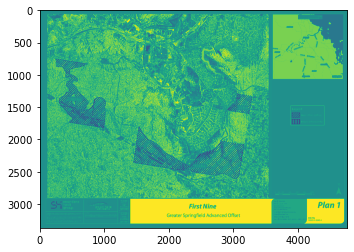

In [13]:
plt.imshow(training_labels)
np.unique(training_labels)

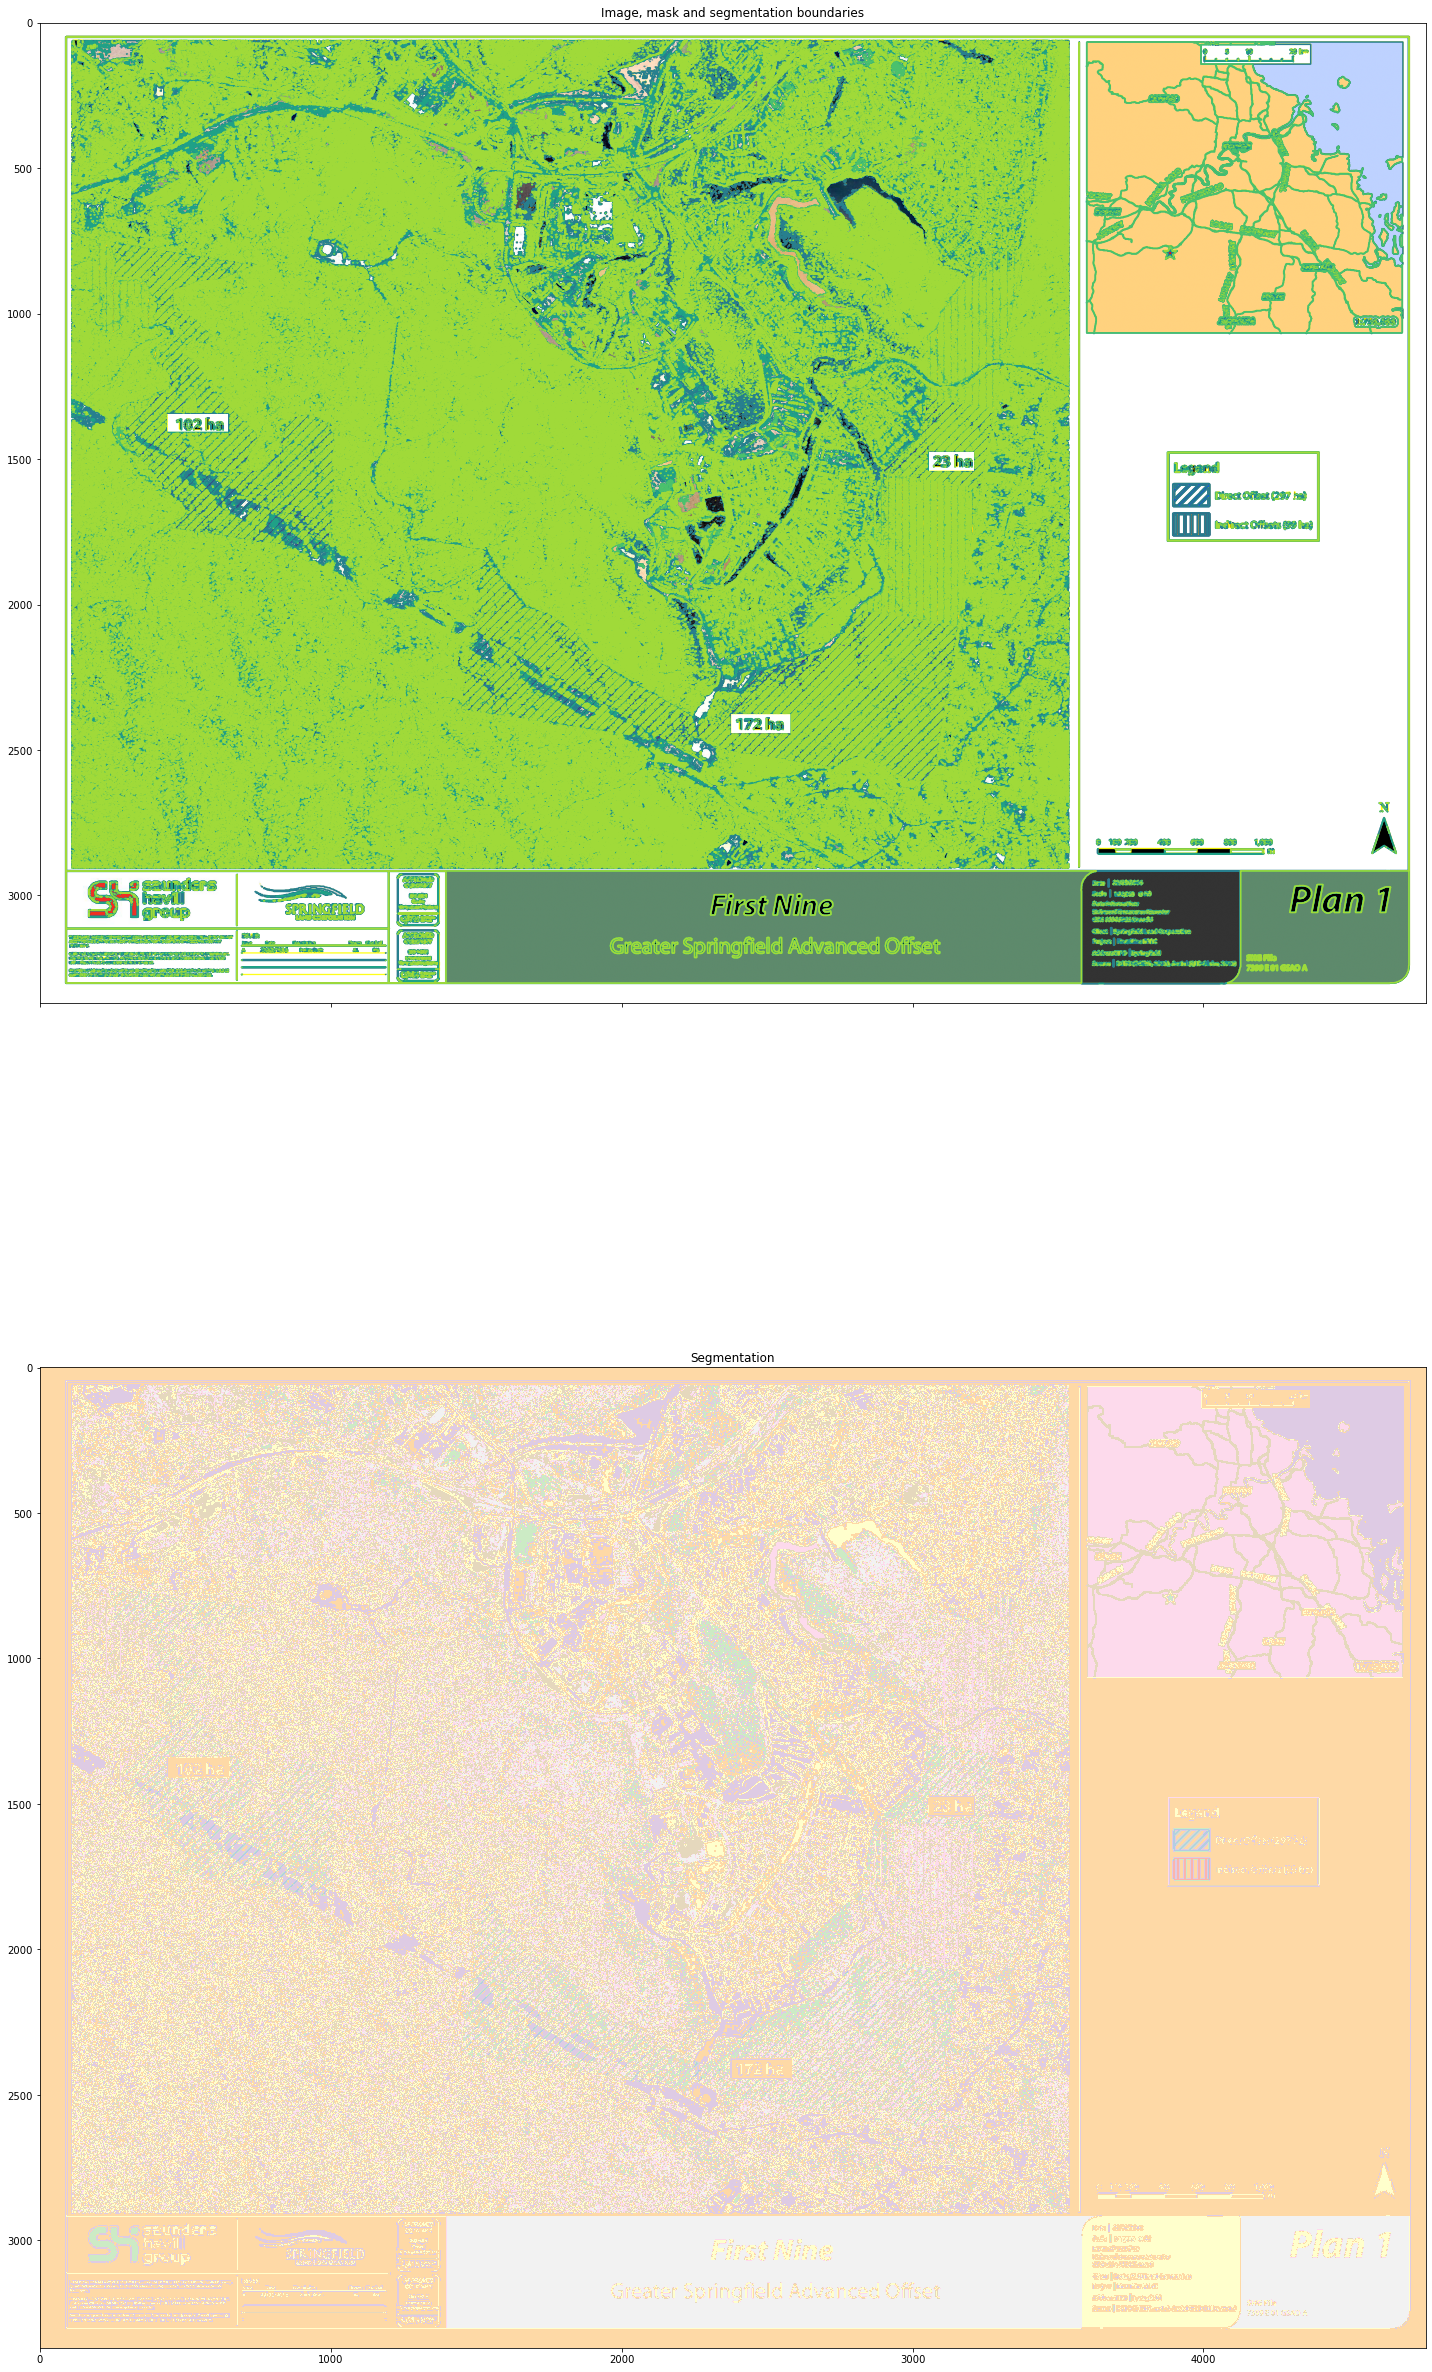

In [14]:
sigma_min = 1
sigma_max = 2
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        multichannel=True)
features = features_func(im1)
clf = RandomForestClassifier(n_estimators=40, n_jobs=-1,
                             max_depth=10, max_samples=0.05)
clf = future.fit_segmenter(training_labels, features, clf)
result = future.predict_segmenter(features, clf)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(20, 40))
ax[0].imshow(segmentation.mark_boundaries(im1, result, mode='thick'))
ax[0].contour(training_labels)
ax[0].set_title('Image, mask and segmentation boundaries')
ax[1].imshow(result, cmap='Pastel1')
ax[1].set_title('Segmentation')
fig.tight_layout()

In [24]:
from PIL import Image, ImageFilter

image = Image.fromarray(result.astype(np.uint8))
result = np.array(image.filter(ImageFilter.ModeFilter(size=1)))
# image.save('output_image.png')

# Manual coordinate extract.

In [15]:
res = [720, 1280]

boxes = []
box_coords = []

# Picture path
img = im1
a = []
b = []

In [16]:
r = img.shape[0] // res[0]
c = img.shape[1] // res[1]

for i in range(r+1):
    for j in range(c+1):
        end_row = min([res[0]*(i+1), img.shape[0]])
        end_col = min([res[1]*(j+1), img.shape[1]])
        box = img[res[0]*i:res[0]*(i+1), res[1]*j:res[1]*(j+1)]
        boxes.append(box)
        box_coords.append([res[0]*i, res[1]*j])

In [67]:
from tkinter import *
from tkinter.filedialog import askopenfilename
from tkinter.simpledialog import askstring
import tkinter as tk
from PIL import Image, ImageTk

points = []
names = []
    
if __name__ == "__main__":

    for i in range(len(boxes)):
        
        root = Tk()
        root.title('Click to choose locations.')
    
        canvas = Canvas(
            root, width = res[1], height = res[0],  cursor='tcross'
        )
        canvas.pack(expand = YES, fill = BOTH)

        im = Image.fromarray(boxes[i])
        ph = ImageTk.PhotoImage(image=im)

        canvas.create_image(0, 0, image = ph, anchor = 'nw')
        #assigned the gif1 to the canvas object
        canvas.ph = ph

        #function to be called when mouse is clicked
        def printcoords(event):
            canvas.create_rectangle(
                event.x-2, event.y-2, event.x+2, event.y+2, width=1,
                fill='red', outline='red'
            )
            name = ''
            while not name:
                name = askstring('Name', root).replace(' ', '_')
            canvas.create_text(
                event.x+10, event.y, anchor=W,
                text=(
                    '(' + str(box_coords[i][1] + event.x) + ', ' 
                    + str(box_coords[i][1] + event.y) + ') '
                    + name
                ), fill='red', font=('Times New Roman', 12)
            )
            points.append(
                (box_coords[i][1] + event.x, box_coords[i][0] + event.y)
            )
            names.append(name)

        canvas.bind("<Button 1>",printcoords)

        root.mainloop()

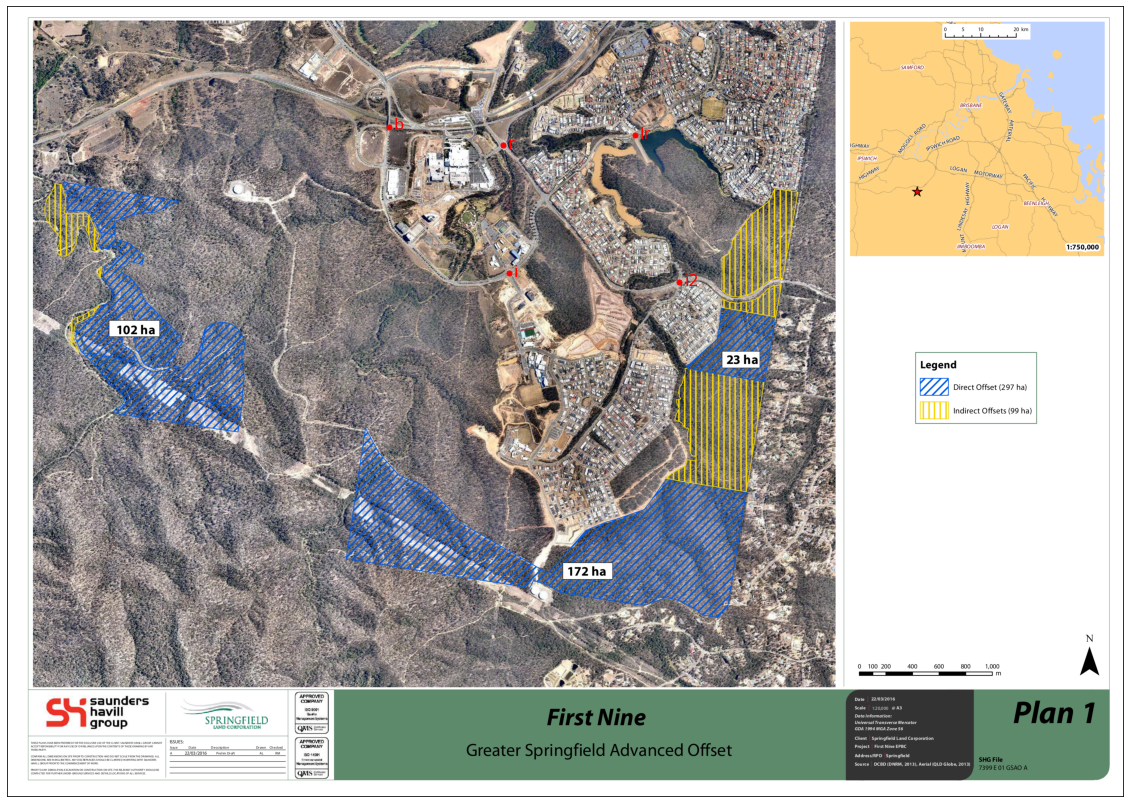

In [69]:
fig, ax = plt.subplots(1, figsize=(20,20))
ax.imshow(img)
for i in range(len(points)):
    ax.plot(points[i][0], points[i][1], '.r', markersize=10)
    ax.text(points[i][0]+20, points[i][1]+12, names[i], color='r', fontsize=16)
    plt.tick_params(        
        which='both',     
        bottom=False,     
        top=False,
        left=False,
        right=False,
        labelbottom=False,
        labelleft=False
    )
fig.savefig('reference.png')

In [143]:
# Here we can usually be more precise by centering on state of project
spread = .03

aus = [133.7751, -25.2744]
qld = [142.7028, -20.9176]
spr = [152.882140, -27.669788]

scaled_points = [
    (
        spread*x[0]/img.shape[0] + spr[0],
        -spread*x[1]/img.shape[1] + spr[1]
    ) for x in points
]

In [144]:
import subprocess
import geojson

In [145]:
subprocess.run('rm -r ' + base_dir + sub_dir + '/JSON', shell=True)
subprocess.run('mkdir ' + base_dir + sub_dir + '/JSON', shell=True)

json_features = []
for i in range(len(scaled_points)):
    json_feature = geojson.Feature(
        geometry=geojson.Point(
            scaled_points[i], precision=8, properties={'Name': names[i]}
        )
    )
    json_features.append(json_feature)
    
for i in range(len(json_features)):
    f = open(base_dir + sub_dir + '/JSON/' + names[i] + '.json', 'w')
    f.write(geojson.dumps(json_features[i], sort_keys=True, indent=4))
    f.close()

In [146]:
subprocess.run(
    'cp ' + base_dir + '/reference.qgs ' + base_dir 
    + sub_dir + '/reference.qgs', shell=True
)
subprocess.run(
    'qgis --project ' + base_dir + sub_dir + '/reference.qgs ' 
    + base_dir + sub_dir + '/JSON/*.json', shell=True
)

CompletedProcess(args='qgis --project /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/map_data/20167676_01042016/reference.qgs /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/map_data/20167676_01042016/JSON/*.json', returncode=0)

In [75]:
coords = []
for i in range(len(points)):
    f = open(base_dir + sub_dir + '/JSON/' + names[i] + '.json', 'r')
    coords.append(geojson.loads(f.read()))
    f.close()

In [76]:
rows = np.array([point[1] for point in points])
cols = np.array([point[0] for point in points])
lons = np.array(
    [coord['geometry']['coordinates'][0] for coord in coords]
)
lats = np.array(
    [coord['geometry']['coordinates'][1] for coord in coords]
)

In [77]:
X = cols/im1.shape[1]
Y = rows/im1.shape[0]

A = np.array([X*0+1, X, Y, X**2, Y**2]).T

c_lon, residuals, rank, s = np.linalg.lstsq(A, lons, rcond=None)
c_lat, residuals, rank, s = np.linalg.lstsq(A, lats, rcond=None)

def evaluate_paraboloid(x,y,coeff):
    c = copy.deepcopy(coeff)
    x = np.array(x)
    y = np.array(y)
    for i in range(len(x.shape)):
        c = np.expand_dims(c, axis=1)
    return (c*np.array([x*0+1, x, y, x**2, y**2])).sum(axis=0)

x = np.arange(im1.shape[1])/im1.shape[1]
y = np.arange(im1.shape[0])/im1.shape[0]
XX, YY = np.meshgrid(x, y)

LON = evaluate_paraboloid(XX, YY, c_lon)
LAT = evaluate_paraboloid(XX, YY, c_lat)

In [78]:
gray = cv.cvtColor(im1, cv.COLOR_BGR2GRAY)

structure = feature.canny(gray, sigma=1).astype(np.uint8)
con_structure, hierarchy = cv.findContours(
    structure, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_TC89_L1
)
main_box = [c for c in con_structure if 0.5*im1_area < cv.contourArea(c) < im1_area]
main_box = cv.drawContours(
    np.zeros_like(gray), main_box, 0, 255, -1
)
legend_box = np.zeros_like(im1[:,:,0])
legend_box[rec[2]:rec[2]+rec[0], rec[3]:rec[3]+rec[1]] = 1

filt_result = copy.deepcopy(result)
filt_result[main_box == 0] = 0
filt_result[legend_box == 1] = 0

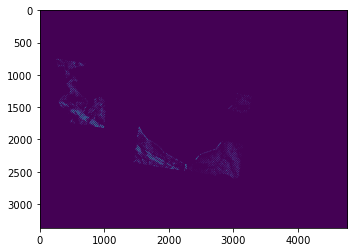

In [108]:
plt.imshow(filt_result==2)

In [83]:
inds = np.unique(leg_obj_labels).tolist()
inds.remove(0)

num_colours = len(inds)
alpha=0.75
cm = pylab.get_cmap('Set1')
poly_colours = []
line_colours = []

for i in range(num_colours):
    cp = list(cm(1.*i/num_colours))
    cline = copy.deepcopy(cp)
    cp[3] = alpha
    cp = to_hex(cp, keep_alpha=True)[1:]
    cp = cp[6:]+cp[4:6]+cp[2:4]+cp[0:2]
    poly_colours.append(cp)
    cline = (np.array(cline)*0.8).tolist()
    cline[3] = alpha
        
    cline = to_hex(cline, keep_alpha=True)[1:]
    cline = cline[6:]+cline[4:6]+cline[2:4]+cline[0:2]
    line_colours.append(cline)

In [85]:
kml = simplekml.Kml()
kml.document.name = file_name

styles = []
for i in range(len(leg_obj_inds)):
    sty = simplekml.Style()
    sty.linestyle.width = 2
    sty.linestyle.color = line_colours[i]
    sty.polystyle.color = poly_colours[i]
    styles.append(sty)
    
for i in range(len(inds)):
    import pdb; pdb.set_trace()
    filled = ndi.binary_fill_holes(filt_result==inds[i])
    obj_size_ratio = 1e-4
    min_size = int(obj_size_ratio*im1.shape[0]*im1.shape[1])
    filled = remove_small_objects(filled, min_size = min_size)
    label_objects, nb_labels = ndi.label(filled)
    label_objects = label_objects.astype(np.uint8)

    obj_contours, hierarchy = cv.findContours(
        label_objects, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_TC89_L1
    )

    poly_coords = [
        [
            (
                LON[obj_contours[i][j][0][1],obj_contours[i][j][0][0]],
                LAT[obj_contours[i][j][0][1],obj_contours[i][j][0][0]],
                1.0
            )
            for j in range(len(obj_contours[i]))
        ]
        for i in range(len(obj_contours))
    ]
    
    if poly_coords:
        fol = kml.newfolder(name=leg_blocks_text[box_nums[i]])
        for j in range(len(poly_coords)):
            poly = fol.newpolygon(
                name = leg_blocks_text[box_nums[i]] + ' ' + str(j+1),
                outerboundaryis = poly_coords[j] + [poly_coords[j][0]],
                altitudemode='relativetoground',                
            )
            poly.style = styles[i]
kml.save(base_dir + sub_dir + '/extracted_polygons.kml')

> <ipython-input-85-d6e39eaa5771>(14)<module>()
     12 for i in range(len(inds)):
     13     import pdb; pdb.set_trace()
---> 14     filled = ndi.binary_fill_holes(filt_result==inds[i])
     15     obj_size_ratio = 1e-4
     16     min_size = int(obj_size_ratio*im1.shape[0]*im1.shape[1])

ipdb> n
> <ipython-input-85-d6e39eaa5771>(15)<module>()
     13     import pdb; pdb.set_trace()
     14     filled = ndi.binary_fill_holes(filt_result==inds[i])
---> 15     obj_size_ratio = 1e-4
     16     min_size = int(obj_size_ratio*im1.shape[0]*im1.shape[1])
     17     filled = remove_small_objects(filled, min_size = min_size)

ipdb> q


BdbQuit: 